# FINAL PROJECT PDE'S COURSE

Primeramente pensamos el problema como uno de autovalores, entonces calculamos el espectro del Hamiltoniano.

In [1]:
path_models         = "../models/";
path_images         = "../images/";
path_modules        = "../modules/"
path_gridap_makie   = "../gridap_makie/";
path_videos         = "./videos/";
path_plots          = "./plots/";

In [2]:
# activamos el proyecto "gridap_makie" donde se intalarán todos los paquetes
import Pkg; Pkg.activate(path_gridap_makie);

install_packages=false;
if install_packages
    import Pkg
    Pkg.add("GridapGmsh");
    Pkg.add("Gmsh");
    Pkg.add("FileIO");
end

using Gridap;
using GridapGmsh;
using Gmsh;

using Plots;

# crear directorios en caso de no haberlo hecho
create_directories = false;
if (create_directories==true)
    mkdir(path_models);
    mkdir(path_images);
end

using FileIO;

# en caso de querer plotear dentro de Jupiter Notebook
#  debemos usar algunos paquetes. (no funciona en VSCode)
plot_s = false;
if plot_s
    using GridapMakie, GLMakie; # Para graficar 
    using FileIO;               # Gráficos y salidas
end

  Activating project at `~/github_repositories/my_repositories/pde2022/final_project/gridap_makie`


### Cargamos paquetes específicos para Algebra Lineal

In [3]:
install_packages=false;
if install_packages
    import Pkg
    Pkg.add("LinearAlgebra");
    Pkg.add("SparseArrays");
    Pkg.add("LinearAlgebra");
    Pkg.add("Arpack");
end
using LinearAlgebra;
using SparseArrays;
using SuiteSparse;
using Arpack;

### Incluimos módulo de funciones para resolver problema de autovalores y creación de mallas de FE

In [4]:
include(path_modules*"module_eigen.jl");  # módulo para resolver problema de autovalores
include(path_models*"mesh_generator.jl"); # módulo para construir grilla (1D)

In [33]:
grid_type="simple_line";                            # tipo de grilla
Δxₕ=1.0/200.0;                                      # tamaño del elento 1D
dom_1D=(-5.0,5.0);                                  # dominio (punto izquierdo y punto derecho)
par_1D=(path_models,grid_type*"_01",dom_1D,Δxₕ);    # (path,name,dom,MeshSize)

model_1D=make_model(grid_type,par_1D);     # creamos modelo
write_data=true
if write_data
    writevtk(model_1D,path_images*"model_1D");  # escribimos el modelo para visualizar con Visit
end

Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.00163726s, CPU 0.001637s)
Info    : 2001 nodes 2002 elements
Info    : Writing '../models/simple_line_01.msh'...
Info    : Done writing '../models/simple_line_01.msh'
Info    : Reading '../models/simple_line_01.msh'...
Info    : 3 entities
Info    : 2001 nodes
Info    : 2002 elements
Info    : Done reading '../models/simple_line_01.msh'


2-element Vector{Vector{String}}:
 ["../images/model_1D_0.vtu"]
 ["../images/model_1D_1.vtu"]

### Definimos condiciones de contorno

In [36]:
# condiciones de contorno
dirichlet_tags_1D=["left_point","right_point"];
dirichlet_values_1D=[(0.0+im*0.0),(0.0+im*0.0)];

### Creamos triangulación de la región de integración y del borde

In [14]:
# the triangulation and integration aproximated Lebesgue measure
function measures(model,degree,tags_boundary)
    # triangulation of the integration domain
    Ω=Triangulation(model);
    dΩ=Measure(Ω,degree);
    # triangulation of the boundary domain whit boundary conditions
    Γ=BoundaryTriangulation(model,tags=tags_boundary);
    dΓ=Measure(Γ,degree)
    return Ω,dΩ,Γ,dΓ;
end

function reference_FEspaces(method,type,order)
    reff=ReferenceFE(method,type,order);
    return reff;
end

reference_FEspaces (generic function with 1 method)

In [38]:
Ω_1D,dΩ_1D,Γ_1D,dΓ_1D=measures(model_1D,3,dirichlet_tags_1D);

### Creamos espacio de referencia para los elementos finitos

In [39]:
reffe_1D=reference_FEspaces(lagrangian,Float64,2);

### Definimos espacio de prueba y espacio de solución

In [40]:
V_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
U_1D=TrialFESpace(V_1D,dirichlet_values_1D);

### Queremos resolver el siguiente problema unidimensional de autovalores:

\begin{align}
    -\frac{\hbar ^{2}}{2m}\frac{\partial }{\partial x}\left(\frac{\partial }{\partial x}\right) \phi(x) +\left[\frac{1}{2} m\omega ^{2}(x-x_{i})^{2}\right] \phi(x) =\lambda \phi(x) \\
    
    \text{si definimos}
    \begin{cases}
        p( x) =\frac{\hbar ^{2}}{2m} \\
        q( x) =\left[\frac{1}{2} m\omega ^{2}(x-x_{i})^{2}\right] \\
        r( x) =1
    \end{cases}
    \Rightarrow \left[ -\frac{d}{dx}\left( p( x)\frac{d}{dx}\right) +q( x)\right] \phi(x) =\lambda r( x) \phi(x) \\
\end{align}
donde los $\phi(x)$ son los autoestados del hamiltoniano nuclear $h_{x_{i}}$

### Definimos funciones para escribir el problema de Sturm-Liouville

In [15]:
# declaramos parámetros constantes
const m=1.0;const ω=1.0;const ħ=1.0;const γ=0.1;const x₁=0.0;const x₂=2.0;

In [16]:
pₕ(x) = 0.5*(ħ*ħ)*(1.0/m);
qₕ(x) = 0.5*m*(ω*ω)*(x[1]-x₁)*(x[1]-x₁);
rₕ(x) = 1.0;

### Definimos formas bilineales para el problema débil

+ Weak Form of the Effective Mass Schrodinger Equation
+ Reference: [https://www.physicsforums.com/threads/weak-form-of-the-effective-mass-schrodinger-equation.751282/](https://www.physicsforums.com/threads/weak-form-of-the-effective-mass-schrodinger-equation.751282/)

In [17]:
# deben verificar la integración por partes
function bilineal_forms(pfunc,qfunc,rfunc,dΩ)
    a(u,v) = ∫(pfunc*∇(v)⋅∇(u)+qfunc*v*u)*dΩ;
    b(u,v) = ∫(rfunc*u*v)dΩ;
    return a,b;
end

bilineal_forms (generic function with 1 method)

In [44]:
aₕ_1D,bₕ_1D=bilineal_forms(pₕ,qₕ,rₕ,dΩ_1D);

### Resolvemos el problema débil de autovalores

In [45]:
nevₕ=12 # number of eigenvalues asked to evaluate.
probₕ_1D=EigenProblem(aₕ_1D,bₕ_1D,U_1D,V_1D;nev=nevₕ,tol=10^(-6),maxiter=100,explicittransform=:none,sigma=-1.0)
ϵₕ_1D,ϕₕ_1D=solve(probₕ_1D);

### Graficamos los autovalores

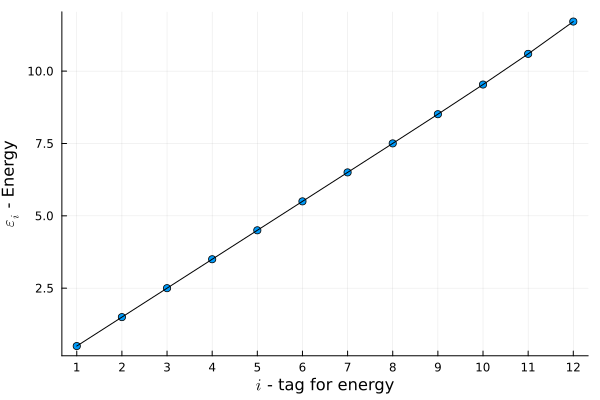

In [70]:
plot1=scatter(real(ϵₕ_1D),label="",xlabel="\$i\$ - tag for energy",ylabel="\$\\epsilon_i\$ - Energy",xticks=(1:1:nevₕ),lw=2)
plot1=plot!(real(ϵₕ_1D),label="",lc=:"black",lw=1)
savefig(plot1,path_plots*"enegies_eigenproblem_1D.pdf");
display(plot1);

### Graficamos las autofunciones

+ [https://arxiv.org/pdf/1910.01412v2.pdf](https://arxiv.org/pdf/1910.01412v2.pdf)
+ [https://gridap.github.io/Tutorials/dev/pages/t015_interpolation_fe/](https://gridap.github.io/Tutorials/dev/pages/t015_interpolation_fe/)

In [49]:
using LinearAlgebra

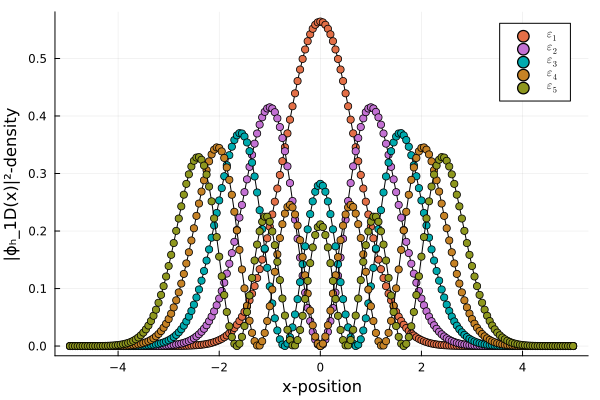

In [62]:
x=[dom_1D[1]+abs(dom_1D[2]-dom_1D[1])*Δxₕ*i for i in 1:convert(Int,1.0/Δxₕ)];
plt=plot();
plot1=plot!(plt,xlabel="x-position",ylabel="|ϕₕ_1D(x)|²-density")
for num_eigenvector in 12:12#nevₕ
    fₕ_1D=interpolate_everywhere(ϕₕ_1D[num_eigenvector],V_1D);
    pts=[Point(x[i]) for i in 1:convert(Int,1.0/Δxₕ)];
    density=real(conj(fₕ_1D.(pts)).*fₕ_1D.(pts))
    plot1=plot!(plt,x,density,label="",lw=1,lc=:"black")
    plot1=scatter!(plt,x,density,label="\$ \\epsilon_{$(num_eigenvector)}\$",lw=2);
end
display(plot1);
savefig(plot1,path_plots*"density_vs_position_eigenproblem_1D.pdf");

### Escribimos autovectores para visualizar con Visit

In [71]:
write_data=false;
if write_data
    for i in 1:nevₕ
        ϕₕi_1D = ϕₕ_1D[i]; # autovector asociado al autovalor 6
        writevtk(Ω_1D,path_images*"eigenprob_1D_01_num$(i)",cellfields=["phi_real" => real(ϕₕi_1D), "phi_imag" => real(ϕₕi_1D)]);
    end
end

> useful links to embeded mp4 inside Markdown Julia
 + [https://developer.mozilla.org/en-US/docs/Web/HTML/Element/video](https://developer.mozilla.org/en-US/docs/Web/HTML/Element/video)
 + [https://www.freeconvert.com/mpeg-to-mp4](https://www.freeconvert.com/mpeg-to-mp4)

### Ahora queremos resolver la dinámica del problema, es decir, la ecuación de evolución (ecuación de Schrödinger dependiente del tiempo)

In [ ]:
# using Gridap.Arrays
# using Gridap.ReferenceFEs
# using Gridap.Algebra

### Creamos la grilla

In [ ]:
n_2D=100;dom_2D=(-5.0,5.0,-5.0,5.0);                    # cantidad de FE y dominio espacial
partition_2D = (n_2D,n_2D);                             # grilla de tamaño n²
model_2D=CartesianDiscreteModel(dom_2D,partition_2D);   # creamos modelo con elementos cartesianos

In [ ]:
write_data=false
if write_data
    writevtk(model_2D,path_images*"model_2D");            # escribimos el modelo para visualizar con Visit
end

In [ ]:
BCtype="fulldirichlet";
if BCtype=="fulldirichlet"
    println("BCtype = ",BCtype);
    # modified
    labels_2D = get_face_labeling(model_2D);
    add_tag_from_tags!(labels_2D,"D1",[1,7,3,2,4,8]);   # lineas laterales + 4 puntos vértice
    add_tag_from_tags!(labels_2D,"D2",[5,6]);           # lineas superior e inferior
    dirichlet_values_2D=[0.0,0.0]; # 0.0+im*0.0
end

### Calculamos las autoenergías, de forma análoga al problema anterior de autovalores, pero extendiendolo a un dominio bidimensional.

In [ ]:
Ω_2D,dΩ_2D,Γ_2D,dΓ_2D=measures(model_2D,3,["D1","D2"]);

In [ ]:
order_2D=2;reffe_2D=ReferenceFE(lagrangian,Float64,order_2D);

In [ ]:
Vₕ_2D=TestFESpace(model_2D,reffe_2D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=["D1","D2"]);
Uₕ_2D=TrialFESpace(Vₕ_2D,dirichlet_values_2D);

In [ ]:
aₕ_2D,bₕ_2D=bilineal_forms(pₕ,qₕ,rₕ,dΩ_2D);
probₕ_2D=EigenProblem(aₕ_2D,bₕ_2D,Uₕ_2D,Vₕ_2D;nev=nevₕ,tol=10^(-6),maxiter=100,explicittransform=:none,sigma=-1.0)
ϵₕ_2D,ϕₕ_2D=solve(probₕ_2D);

In [ ]:
# guardamos los datos para visualización con Visit
write_data=true
if write_data
    for i in 1:nevₕ
        ϕₕi_2D = ϕₕ_2D[i]; # autovector asociado al autovalor i
        writevtk(Ω_2D,path_images*"eigenprob_2D_01_num$(i)",cellfields=["phi_real" => real(ϕₕi_2D), "phi_imag" => real(ϕₕi_2D)]);
    end
end

In [ ]:
T=5;            # final time for test
num_steps=2000; # number of time steps   
n_int=100;      # Intervals where data is saved

+ El factor $\frac {dt}{dx^2}$ nos permite corroborar que, si es pequeño $( \lt 1)$, el método de Euler usual funcionaría.
+ El factor $\frac {dt}{dx}$ si es aproximadamente igual a 1, y no usamos métodos implícitos, el método explícito sería intestable.
+ El factor $\frac {dt^3}{dx^6}$ nos dice cómo escala el error del método implícito.

In [ ]:
dt=T/(num_steps-1) # time step
println("dt/dx²=$(dt/(h_1D^2)) dt/dx=$(dt/h_1D) dt³/dx⁶=$((dt/(h_1D^2))^3)");   # caso 1D
println("dt/dx²=$(dt*(n_2D^2)) dt/dx=$(dt*n_2D) dt³/dx⁶=$((dt*(n_2D^2))^3)");   # caso 2D

In [18]:
function norm_L2(u,dΩ)
    return sqrt(real(sum(∫(u'*u)*dΩ)));
end

norm_L2 (generic function with 1 method)

In [ ]:
# espacio de pruebas y de soluciones para ψ₁
V₁H_2D=TestFESpace(model_2D,reffe_2D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=["D1","D2"]);
U₁H_2D=TrialFESpace(V₁H_2D,dirichlet_values_2D);
# espacio de pruebas y de soluciones para ψ₂
V₂H_2D=TestFESpace(model_2D,reffe_2D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=["D1","D2"]);
U₂H_2D=TrialFESpace(V₂H_2D,dirichlet_values_2D);
# creamos un campo de espacios
UH_2D = MultiFieldFESpace([U₁H_2D, U₂H_2D]);
VH_2D = MultiFieldFESpace([V₁H_2D, V₂H_2D]);

### construimos la condición inicial

In [ ]:
using Gridap.CellData;
u₀ₕ_2D=interpolate_everywhere(ϕₕ_2D[1],Vₕ_2D);
interp_u₀ₕ_2D=Interpolable(u₀ₕ_2D);
u₁0H_2D=interpolate_everywhere(interp_u₀ₕ_2D,V₁H_2D);

In [ ]:
u₂0H_2D(x) = 0.0;

In [ ]:
u₀H_2D=interpolate_everywhere([u₁0H_2D,u₂0H_2D],VH_2D);

In [ ]:
if write_data
    writevtk(Ω_2D,path_images*"evol_ini_dat_$(lpad(0,3,'0'))", cellfields=["u₁0H_2D_re"=>real(u₀H_2D[1]),"u₁0H_2D_im"=>imag(u₀H_2D[1])])
end
norm_L2(u₀H_2D[1],dΩ_2D)

In [19]:
const α=im*ħ*0.5*(1.0/m); const αconst=-im*0.5*m*(ω*ω)*(1.0/ħ); const β=-im*γ*(1.0/ħ);
α₁(x)=αconst*(x[1]-x₁)*(x[1]-x₁);
α₂(x)=αconst*(x[1]-x₂)*(x[1]-x₂);

In [ ]:
assem_H=SparseMatrixAssembler(UH_2D,VH_2D);       # ensamblamos una matriz sparse con U y V
dv_H=get_fe_basis(VH_2D);                         # escribimos v en la base de FE de V            
du_H=get_trial_fe_basis(UH_2D);                   # escribimos u en la base de FE de U

In [20]:
# deben verificar la integración por partes
function a_bilineal_forms_2D(α₁,α₂,Δt,dΩ)
    a((u₁,u₂),(v₁,v₂))=∫((2-β)*(u₁*v₁+u₂*v₂)-(α₁*u₁*v₁+α₂*u₂*v₂)-α*(∇(v₁)⋅∇(u₁)+∇(v₂)⋅∇(u₂))*Δt)*dΩ
    return a;
end

function b_bilineal_form_2D(α₁,α₂,u₀₁,u₀₂,Δt,dΩ)
    b(v₁,v₂)=∫((2+β)*(u₀₁*v₁+u₀₂*v₂)+(α₁*u₀₁*v₁+α₂*u₀₂*v₂)+α*(∇(v₁)⋅∇(u₀₁)+∇(v₂)⋅∇(u₀₂))*Δt)*dΩ
    return b;
end

b_bilineal_form_2D (generic function with 1 method)

In [ ]:
using Gridap.FESpaces;
a_H_2D=a_bilineal_forms_2D(α₁,α₂,dt,dΩ_2D);
mat_contribs_H=a_H_2D(du_H,dv_H);                      # creamos una matriz de bases (contribuciones)
data_H=collect_cell_matrix(UH_2D,VH_2D,mat_contribs_H); # recolectamos una matriz (datos)
A_H=assemble_matrix(assem_H,data_H);              # creamos matriz A con contribuciones y datos

In [ ]:
t=0;  # inicializamos variable tiempo
if write_data
  writevtk(Ω_2D,path_images*"evol__$(lpad(0,3,'0'))",
  cellfields=["u₁H_2D_re" => real(u₀H_2D[1]), "u₁H_2D_im" => imag(u₀H_2D[1]),"u₂H_2D_re" => real(u₀H_2D[2]), "u₂H_2D_im" => imag(u₀H_2D[2])])
end

for istep in 1:num_steps
  # println("\n+++ Solving in step $istep of $num_steps +++\n")
  b_H_2D=b_bilineal_form_2D(α₁,α₂,u₀H_2D[1],u₀H_2D[2],dΩ_2D)
  vec_contribs_H=b_H_2D(dv_H[1],dv_H[2])
  data_H=collect_cell_vector(VH_2D,vec_contribs_H)
  b_H=assemble_vector(assem_H,data_H)

  x_H = A_H \ b_H
  t = t + dt
  uH_2D = FEFunction(UH_2D,x_H)

  u₀H_2D = uH_2D

  if ((istep - 1) % n_int == 0) && (istep > 1) && (write_data)
    writevtk(Ω_2D,path_images*"evol__$(lpad(istep,3,'0'))",
    cellfields=[ "u₁H_2D_re" => real(u₀H_2D[1]), "u₁H_2D_im" => imag(u₀H_2D[1]),"u₂H_2D_re" => real(u₀H_2D[2]), "u₂H_2D_im" => imag(u₀H_2D[2])])
  end
end

### Mostramos salida de Densidad de probabilidad con visualizador Visit

<video controls width="500">
  <source src="./videos/density_pseudocolor_01.mp4" type="video/mp4" />
</video>

<video controls width="500">
  <source src="./videos/density_trace_01.mp4" type="video/mp4" />
</video>

### Ahora jugamos un poco con los parámetros

In [14]:
include(path_models*"mesh_generator.jl"); # módulo para construir grilla (1D)

In [15]:
grid_type="simple_rectangle";                               # tipo de grilla
Δgrid=1.0e-1;                                               # tamaño del elento 1D
dom_2D=(-5.0,5.0,-5.0,5.0);                                 # dominio (punto izquierdo y punto derecho)
par_2D=(path_models,grid_type*"_01",dom_2D,Δgrid,false);    # (path,name,dom,MeshSize,quad_state)

model_2D=make_model(grid_type,par_2D);                      # creamos modelo

Info    : Reading '../models/simple_rectangle_01.msh'...
Info    : 9 entities
Info    : 11824 nodes
Info    : 23650 elements
Info    : Done reading '../models/simple_rectangle_01.msh'


In [16]:
write_data=false
if write_data
    writevtk(model_2D,path_images*grid_type*"model_2D_triangles");  # escribimos el modelo para visualizar con Visit
end

In [17]:
# condiciones de contorno
dirichlet_tags_2D=["ext_points","ext_lines"];
dirichlet_values_2D=[(0.0+im*0.0),(0.0+im*0.0)];

In [18]:
Ω_2D,dΩ_2D,Γ_2D,dΓ_2D=measures(model_2D,3,dirichlet_tags_2D);

In [19]:
order_2D=2;reffe_2D=ReferenceFE(lagrangian,Float64,order_2D);

In [20]:
Vₕ_2D=TestFESpace(model_2D,reffe_2D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_2D);
Uₕ_2D=TrialFESpace(Vₕ_2D,dirichlet_values_2D);

In [21]:
nevₕ=12;
aₕ_2D,bₕ_2D=bilineal_forms(pₕ,qₕ,rₕ,dΩ_2D);
probₕ_2D=EigenProblem(aₕ_2D,bₕ_2D,Uₕ_2D,Vₕ_2D;nev=nevₕ,tol=10^(-6),maxiter=100,explicittransform=:none,sigma=-1.0)
ϵₕ_2D,ϕₕ_2D=solve(probₕ_2D);

In [ ]:
# guardamos los datos para visualización con Visit
write_data=false
if write_data
    for i in 1:nevₕ
        ϕₕi_2D = ϕₕ_2D[i]; # autovector asociado al autovalor i
        writevtk(Ω_2D,path_images*"eigenprob_2D_02_num$(i)",cellfields=["phi_real" => real(ϕₕi_2D), "phi_imag" => real(ϕₕi_2D)]);
    end
end

### Mostramos salida de Densidad de probabilidad de 12 autoestados con visualizador Visit (problema de autovalores en 2D)

<div>
  <video controls width="500">
    <source src="./videos/eigenstates_2D.mp4" type="video/mp4" />
  </video>
  
  <img src="./plots/triangular_mesh_01.jpeg" width="500"/>
</div>

### Creamos espacios de prueba y solución

In [47]:
# espacio de pruebas y de soluciones para ψ₁
V₁H_2D=TestFESpace(model_2D,reffe_2D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=["ext_points","ext_lines"]);
U₁H_2D=TrialFESpace(V₁H_2D,dirichlet_values_2D);
# espacio de pruebas y de soluciones para ψ₂
V₂H_2D=TestFESpace(model_2D,reffe_2D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=["ext_points","ext_lines"]);
U₂H_2D=TrialFESpace(V₂H_2D,dirichlet_values_2D);
# creamos un campo de espacios
UH_2D = MultiFieldFESpace([U₁H_2D, U₂H_2D]);
VH_2D = MultiFieldFESpace([V₁H_2D, V₂H_2D]);

### Definimos codición inicial

In [53]:
using Gridap.CellData;
u₀ₕ_2D=interpolate_everywhere(ϕₕ_2D[1],Vₕ_2D);
interp_u₀ₕ_2D=Interpolable(u₀ₕ_2D);
u₁0H_2D=interpolate_everywhere(interp_u₀ₕ_2D,V₁H_2D);

u₂0H_2D(x) = 0.0;

u₀H_2D=interpolate_everywhere([u₁0H_2D,u₂0H_2D],VH_2D);

assem_H=SparseMatrixAssembler(UH_2D,VH_2D);       # ensamblamos una matriz sparse con U y V
dv_H=get_fe_basis(VH_2D);                         # escribimos v en la base de FE de V            
du_H=get_trial_fe_basis(UH_2D);                   # escribimos u en la base de FE de U

### Definimos parámetros de evolución temporal y evolucionamos

In [54]:
t₁=0.0;t₂ =1.0; # start and final time
Nₜ=30; # number of time steps   
N_SaveData=1;      # Intervals where data is saved

Δt=abs(t₂-t₁)*(1.0/(Nₜ-1)) # time step
println("Δt/Δx²=$(Δt/(Δgrid^2)) Δt/Δx=$(Δt/Δgrid) Δt³/Δx⁶=$((Δt/(Δgrid^2))^3)");   # caso 2D

Δt/Δx²=3.448275862068965 Δt/Δx=0.03003003003003003 Δt³/Δx⁶=41.00209110664642


In [ ]:
using Gridap.FESpaces;
a_H_2D=a_bilineal_forms_2D(α₁,α₂,Δt,dΩ_2D);
mat_contribs_H=a_H_2D(du_H,dv_H);                       # creamos una matriz de bases (contribuciones)
data_H=collect_cell_matrix(UH_2D,VH_2D,mat_contribs_H); # recolectamos una matriz (datos)
A_H=assemble_matrix(assem_H,data_H);                    # creamos matriz A con contribuciones y datos

In [55]:
# t=t₁;  # inicializamos variable tiempo
# escribimos data a tiempo inicial
write_data=true
if write_data
  writevtk(Ω_2D,path_images*"evol_v2__$(lpad(0,3,'0'))",
  cellfields=["u₁H_2D_re" => real(u₀H_2D[1]), "u₁H_2D_im" => imag(u₀H_2D[1]),"u₂H_2D_re" => real(u₀H_2D[2]), "u₂H_2D_im" => imag(u₀H_2D[2])])
end

for istep in 1:Nₜ

  b_H_2D=b_bilineal_form_2D(α₁,α₂,u₀H_2D[1],u₀H_2D[2],dΩ_2D)
  vec_contribs_H=b_H_2D(dv_H[1],dv_H[2])
  data_H=collect_cell_vector(VH_2D,vec_contribs_H)
  b_H=assemble_vector(assem_H,data_H)

  x_H = A_H \ b_H
  uH_2D = FEFunction(UH_2D,x_H)

  u₀H_2D = uH_2D

  # escribimos data a tiempo evolucionado
  if ((istep - 1) % N_SaveData == 0) && (istep > 1) && (write_data)
    writevtk(Ω_2D,path_images*"evol_v2__$(lpad(istep,3,'0'))",
    cellfields=[ "u₁H_2D_re" => real(u₀H_2D[1]), "u₁H_2D_im" => imag(u₀H_2D[1]),"u₂H_2D_re" => real(u₀H_2D[2]), "u₂H_2D_im" => imag(u₀H_2D[2])])
  end

  # t=t₁+Δt*i;
end

### Mostramos salida de Densidad de probabilidad con visualizador Visit

Las diferentes configuraciones son
+ configuración 02: $t_{end}=5$[s], $N_{t}=2000$ [steps] y $N_{SaveData}=100$ [step]
+ configuración 03: $t_{end}=1$[s], $N_{t}=30$ [steps] y $N_{SaveData}=1$ [step]

### Configuration 02 (pseudocolor density 2D)
<div>
  <video controls width="500" height="500">
    <source src="./videos/density_pseudocolor_02.mp4" type="video/mp4" />
  </video>
</div>

### Configuration 03 (pseudocolor density 3D and trace density)
<div>
  <video controls width="500" height="500">
    <source src="./videos/density_pseudocolor_03.mp4" type="video/mp4" />
  </video>
  <video controls width="500" height="500">
    <source src="./videos/density_trace_03.mp4" type="video/mp4" />
  </video>
</div>

### ¿Y si simulamos un hamiltoniano bidimensional?

In [5]:
include(path_models*"mesh_generator.jl"); # módulo para construir grilla (1D)
include(path_modules*"module_schrodinger_equation_01.jl"); # módulo para construir grilla (1D)

  Activating project at `~/github_repositories/my_repositories/pde2022/final_project/gridap_makie`


In [6]:
grid_type="simple_rectangle";                               # tipo de grilla
Δgrid=1.0e-1;                                               # tamaño del elento 1D
dom_2D=(-3.0,3.0,-3.0,3.0);                                 # dominio (punto izquierdo y punto derecho)
par_2D=(path_models,grid_type*"_01",dom_2D,Δgrid,false);    # (path,name,dom,MeshSize,quad_state)

model_2D=make_model(grid_type,par_2D);                      # creamos modelo

Info    : Reading '../models/simple_rectangle_01.msh'...
Info    : 9 entities
Info    : 4337 nodes
Info    : 8676 elements
Info    : Done reading '../models/simple_rectangle_01.msh'


In [7]:
# condiciones de contorno
dirichlet_tags_2D=["ext_points","ext_lines"];
dirichlet_values_2D=[(0.0+im*0.0),(0.0+im*0.0)];

In [8]:
Ω_2D,dΩ_2D,Γ_2D,dΓ_2D=measures(model_2D,3,dirichlet_tags_2D);
order_2D=2;reffe_2D=ReferenceFE(lagrangian,Float64,order_2D);
Vₕ_2D=TestFESpace(model_2D,reffe_2D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_2D);
Uₕ_2D=TrialFESpace(Vₕ_2D,dirichlet_values_2D);

In [86]:
# declaramos parámetros constantes
const y₁=0.0;const y₂=2.0;

In [87]:
qₕ_2D(x) = 0.5*m*(ω*ω)*((x[1]-x₁)*(x[1]-x₁)+(x[2]-y₁)*(x[2]-y₁));

In [9]:
nevₕ=12;
aₕ_2D,bₕ_2D=bilineal_forms(pₕ,qₕ_2D,rₕ,dΩ_2D);
probₕ_2D=EigenProblem(aₕ_2D,bₕ_2D,Uₕ_2D,Vₕ_2D;nev=nevₕ,tol=10^(-6),maxiter=100,explicittransform=:none,sigma=-1.0)
ϵₕ_2D,ϕₕ_2D=solve(probₕ_2D);

In [10]:
# guardamos los datos para visualización con Visit
write_data=true
if write_data
    for i in 1:nevₕ
        ϕₕi_2D = ϕₕ_2D[i]; # autovector asociado al autovalor i
        writevtk(Ω_2D,path_images*"eigenprob_2D_03_num$(i)",cellfields=["phi_real" => real(ϕₕi_2D), "phi_imag" => real(ϕₕi_2D)]);
    end
end

In [11]:
# espacio de pruebas y de soluciones para ψ₁
V₁H_2D=TestFESpace(model_2D,reffe_2D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=["ext_points","ext_lines"]);
U₁H_2D=TrialFESpace(V₁H_2D,dirichlet_values_2D);
# espacio de pruebas y de soluciones para ψ₂
V₂H_2D=TestFESpace(model_2D,reffe_2D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=["ext_points","ext_lines"]);
U₂H_2D=TrialFESpace(V₂H_2D,dirichlet_values_2D);
# creamos un campo de espacios
UH_2D = MultiFieldFESpace([U₁H_2D, U₂H_2D]);
VH_2D = MultiFieldFESpace([V₁H_2D, V₂H_2D]);

In [12]:
using Gridap.CellData;
u₀ₕ_2D=interpolate_everywhere(ϕₕ_2D[1],Vₕ_2D);
interp_u₀ₕ_2D=Interpolable(u₀ₕ_2D);
u₁0H_2D=interpolate_everywhere(interp_u₀ₕ_2D,V₁H_2D);

u₂0H_2D(x) = 0.0;

u₀H_2D=interpolate_everywhere([u₁0H_2D,u₂0H_2D],VH_2D);

assem_H=SparseMatrixAssembler(UH_2D,VH_2D);       # ensamblamos una matriz sparse con U y V
dv_H=get_fe_basis(VH_2D);                         # escribimos v en la base de FE de V            
du_H=get_trial_fe_basis(UH_2D);                   # escribimos u en la base de FE de U

In [71]:
α₁_2D(x)=αconst*((x[1]-x₁)*(x[1]-x₁)+(x[2]-y₁)*(x[2]-y₁));
α₂_2D(x)=αconst*((x[1]-x₂)*(x[1]-x₂)+(x[2]-y₂)*(x[2]-y₂));

In [13]:
t₁=0.0;t₂ =1.0; # start and final time
Nₜ=30; # number of time steps   
N_SaveData=1;      # Intervals where data is saved

Δt=abs(t₂-t₁)*(1.0/(Nₜ-1)) # time step
println("Δt/Δx²=$(Δt/(Δgrid^2)) Δt/Δx=$(Δt/Δgrid) Δt³/Δx⁶=$((Δt/(Δgrid^2))^3)");   # caso 2D

Δt/Δx²=3.448275862068965 Δt/Δx=0.3448275862068965 Δt³/Δx⁶=41.00209110664642


In [14]:
using Gridap.FESpaces;
a_H_2D=a_bilineal_forms_2D(α₁_2D,α₂_2D,Δt,dΩ_2D);
mat_contribs_H=a_H_2D(du_H,dv_H);                       # creamos una matriz de bases (contribuciones)
data_H=collect_cell_matrix(UH_2D,VH_2D,mat_contribs_H); # recolectamos una matriz (datos)
A_H=assemble_matrix(assem_H,data_H);                    # creamos matriz A con contribuciones y datos

In [15]:
display(A_H);

33250×33250 SparseMatrixCSC{ComplexF64, Int64} with 376306 stored entries:
⣿⣿⣿⣿⣿⣹⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣏⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⣟⣻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣻⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⣿⣿⣿⣿⣿⣻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⡿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣹⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣍
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣟⣻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟⣿⣿⣿⣿⣿⣿⣿⣿
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡟
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡟⢿⣿⣿⣿⣿⢿⣿⣿⣿⣿⠿⢿⣿⢿⣿⣿⣿⣿⣿

In [16]:
# t=t₁;  # inicializamos variable tiempo
# escribimos data a tiempo inicial
write_data=true
if write_data
  writevtk(Ω_2D,path_images*"evol_2D_03_$(lpad(0,3,'0'))",
  cellfields=["u₁H_2D_re" => real(u₀H_2D[1]), "u₁H_2D_im" => imag(u₀H_2D[1]),"u₂H_2D_re" => real(u₀H_2D[2]), "u₂H_2D_im" => imag(u₀H_2D[2])])
end

for istep in 1:Nₜ

  b_H_2D=b_bilineal_form_2D(α₁,α₂,u₀H_2D[1],u₀H_2D[2],Δt,dΩ_2D)
  vec_contribs_H=b_H_2D(dv_H[1],dv_H[2])
  data_H=collect_cell_vector(VH_2D,vec_contribs_H)
  b_H=assemble_vector(assem_H,data_H)

  x_H = A_H \ b_H
  uH_2D = FEFunction(UH_2D,x_H)

  u₀H_2D = uH_2D

  # escribimos data a tiempo evolucionado
  if ((istep - 1) % N_SaveData == 0) && (istep > 1) && (write_data)
    writevtk(Ω_2D,path_images*"evol_2D_03_$(lpad(istep,3,'0'))",
    cellfields=[ "u₁H_2D_re" => real(u₀H_2D[1]), "u₁H_2D_im" => imag(u₀H_2D[1]),"u₂H_2D_re" => real(u₀H_2D[2]), "u₂H_2D_im" => imag(u₀H_2D[2])])
  end

  # t=t₁+Δt*i;
end